### Import libraris and methods

In [ ]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, BatchNormalization , GRU
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling1D, GlobalAveragePooling2D, Flatten, MaxPool2D, Conv1D, MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from keras.utils import to_categorical
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import io
import ast

2025-07-14 18:25:23.183144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 18:25:23.418723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 18:25:23.512564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 18:25:23.540928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 18:25:23.720889: I tensorflow/core/platform/cpu_feature_guar

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


I0000 00:00:1752504926.962834   89311 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1752504927.204490   89311 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1752504927.204551   89311 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### Extract features from mel-spec of audios

In [ ]:
def extract_features_gpt(y, sr):
    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=512)
    
    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=y)
    
    # Root Mean Square Energy
    rms = librosa.feature.rms(y=y)
    
    # Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    
    # Spectral Bandwidth
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    
    # Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    # Tonnetz (harmonic features)
    y_harmonic = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    
    # Aggregate using mean and std
    def stat(feat):
        return np.concatenate([np.mean(feat, axis=1), np.std(feat, axis=1)])
    
    features = np.concatenate([
        stat(mfccs),
        stat(chroma),
        stat(zcr),
        stat(rms),
        stat(spec_centroid),
        stat(spec_bw),
        stat(spec_contrast),
        stat(rolloff),
        stat(tonnetz)
    ])
    
    return features

#### Data Augmentations with Noise, Stretch, Shift and Pitch

In [83]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)   

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(data, sr, duration=2.5, offset=0.6):

    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))  
    return audio

In [82]:
df = pd.read_csv("train.csv")
df

,audio_id,audio,speaker_id,gender,emotion,transcript,ipa
0,F21S17,{'bytes': b'RIFF4(\x02\x00WAVEfmt \x10\x00\x00...,F21,female,sad,از زندان بردنش.,ʔæz zendɑn bordæneʃ
1,M53A13,{'bytes': b'RIFF\xf8_\x05\x00WAVEfmt \x10\x00\...,M53,male,angry,وصلت با یک بیگانه یعنی انهدام مملکت و حکومت چین,væslæt bɑ yek bigɑne yæʔni ʔenhedɑme mæmlekæt ...
2,M12N84,{'bytes': b'RIFF>\xd9\x02\x00WAVEfmt \x10\x00\...,M12,male,neutral,ممکنه تو اروپا خریده باشنش,momkene tu ʔorupɑ xӕride bɑʃӕneʃ
3,F01S21,{'bytes': b'RIFFn\x81\x07\x00WAVEfmt \x10\x00\...,F01,female,sad,خیلی دوست داشت یه روزی بره کربلا، اونوقت‎ها هم...,xeyli dust dɑʃt ye ruzi bere kӕrbӕlɑ ʔun vӕxtɑ...
4,M12A51,"{'bytes': b'RIFF""\x15\x03\x00WAVEfmt \x10\x00\...",M12,male,angry,متشکرم برادر عزیز,motʃtʃækeræm bærɑdære ʔæziz
...,...,...,...,...,...,...,...
2265,M48N09,{'bytes': b'RIFFB\xd3\x02\x00WAVEfmt \x10\x00\...,M48,male,neutral,بله ساعتتونو، ساعت مچی قشنگو قیمتی‎ایه,bӕle sɑʔætetuno sɑʔæte motʃiye qæʃængo qeymæti...
2266,M04N39,{'bytes': b'RIFF\xaa\xba\x06\x00WAVEfmt \x10\x...,M04,male,neutral,و از اعمال زشت و خودخواهانۀ اون به شدت رنج میکشه,væ ʔæz ʔæʔӕmmɑl zeʃto xodxɑhɑneye ʔun be ʃeddæ...
2267,M06A01,"{'bytes': b'RIFF~""\x01\x00WAVEfmt \x10\x00\x00...",M06,male,angry,ولی تا کِی؟,væli tɑ key
2268,M12N21,{'bytes': b'RIFF\x86v\x02\x00WAVEfmt \x10\x00\...,M12,male,neutral,همراه آن‎ها به شکار می‎رفتم,hæmrɑhe ʔɑnhɑ be ʃekɑr miræftæm


In [ ]:
def get_audios(df):
    
    audios = []
    for i in range(len(df)):
        audio_dict = ast.literal_eval(df.iloc[i]["audio"])
        audio_bytes = audio_dict['bytes']
        audio_file = io.BytesIO(audio_bytes)
        y, sr = librosa.load(audio_file, sr=44100)
        audios.append((y, sr))
    
    return audios

In [86]:
def change_label_to_num(emotion_class : str):
    if emotion_class == "sad":
        return 0
    elif emotion_class == "happy":
        return 1
    elif emotion_class == "angry":
        return 2
    elif emotion_class == "neutral":
        return 3
    elif emotion_class == "surprised":
        return 4
    elif emotion_class == "fearful":
        return 5
    

In [87]:
labels = []
for i in range(len(df)):
    emotion = df.iloc[i]["emotion"]
    labels.append(change_label_to_num(emotion))
    labels.append(change_label_to_num(emotion))

In [ ]:
def get_audios_feature(df):
    X = []
    counter = 0
    audios = get_audios(df)
    for  y, sr in audios:
        features = get_features(y, sr)
        # features = get_features(y, sr)
        for feature in features:
            X.append(feature)
        counter += 1
        print(counter)
    return X 

#### Change features to dataframe

In [ ]:
X = get_audios_feature(df)
audio_df = pd.DataFrame(X)
audio_df

In [ ]:
audios_df = audio_df.iloc[:, :3000]
audios_df

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.234863,0.261230,0.274902,0.074219,0.056641,0.042969,0.038086,0.039062,0.037598,0.031738,...,-17.060024,-5.176028,19.868469,11.421150,22.070356,-5.748923,-4.181462,13.790880,-266.129028,173.944641
1,0.242188,0.310059,0.334961,0.217773,0.110352,0.058594,0.045898,0.047852,0.051270,0.045410,...,-6.995174,-3.836904,11.348092,16.134923,10.381916,-3.728390,-3.496824,4.431642,-149.649169,59.838775
2,0.144043,0.263184,0.404785,0.503906,0.480469,0.406738,0.299805,0.147461,0.089355,0.050293,...,-7.994487,20.774094,16.310749,14.888670,6.094055,-28.473404,-6.038557,-3.982696,-4.619328,5.838830
3,0.236328,0.363281,0.488281,0.484375,0.500977,0.496582,0.505371,0.510742,0.506836,0.487305,...,31.972490,10.527021,23.576022,13.929982,-1.758308,-16.012954,-14.129057,-3.375284,-0.210493,-0.143204
4,0.155762,0.195312,0.247070,0.234863,0.245605,0.229492,0.180664,0.097168,0.030273,0.010742,...,6.869188,12.267647,36.839630,-6.920565,27.048504,14.474182,3.677302,14.293736,2.155931,14.267382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,0.145508,0.158203,0.176270,0.081055,0.060547,0.069336,0.060059,0.060547,0.065918,0.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4536,0.150391,0.192383,0.231934,0.187012,0.131836,0.114258,0.107422,0.103027,0.083984,0.065918,...,-7.509294,-29.411709,7.180375,20.280077,-7.356036,4.584832,-395.468018,163.804565,22.478168,36.808239
4537,0.246582,0.365234,0.487305,0.489746,0.481934,0.480469,0.468262,0.419922,0.315430,0.213379,...,-4.841320,-5.354630,0.122296,0.611067,4.978406,4.838432,-223.222946,45.674605,31.344569,20.859715
4538,0.018066,0.033203,0.039551,0.077148,0.128418,0.147461,0.187500,0.222168,0.231934,0.262695,...,-16.007833,24.945744,-0.663407,39.263603,32.155556,-24.300934,7.564744,-12.221015,-9.397395,17.272532


In [ ]:
audios_df = audios_df.fillna(0)
audios_df

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.234863,0.261230,0.274902,0.074219,0.056641,0.042969,0.038086,0.039062,0.037598,0.031738,...,-17.060024,-5.176028,19.868469,11.421150,22.070356,-5.748923,-4.181462,13.790880,-266.129028,173.944641
1,0.242188,0.310059,0.334961,0.217773,0.110352,0.058594,0.045898,0.047852,0.051270,0.045410,...,-6.995174,-3.836904,11.348092,16.134923,10.381916,-3.728390,-3.496824,4.431642,-149.649169,59.838775
2,0.144043,0.263184,0.404785,0.503906,0.480469,0.406738,0.299805,0.147461,0.089355,0.050293,...,-7.994487,20.774094,16.310749,14.888670,6.094055,-28.473404,-6.038557,-3.982696,-4.619328,5.838830
3,0.236328,0.363281,0.488281,0.484375,0.500977,0.496582,0.505371,0.510742,0.506836,0.487305,...,31.972490,10.527021,23.576022,13.929982,-1.758308,-16.012954,-14.129057,-3.375284,-0.210493,-0.143204
4,0.155762,0.195312,0.247070,0.234863,0.245605,0.229492,0.180664,0.097168,0.030273,0.010742,...,6.869188,12.267647,36.839630,-6.920565,27.048504,14.474182,3.677302,14.293736,2.155931,14.267382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,0.145508,0.158203,0.176270,0.081055,0.060547,0.069336,0.060059,0.060547,0.065918,0.062500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4536,0.150391,0.192383,0.231934,0.187012,0.131836,0.114258,0.107422,0.103027,0.083984,0.065918,...,-7.509294,-29.411709,7.180375,20.280077,-7.356036,4.584832,-395.468018,163.804565,22.478168,36.808239
4537,0.246582,0.365234,0.487305,0.489746,0.481934,0.480469,0.468262,0.419922,0.315430,0.213379,...,-4.841320,-5.354630,0.122296,0.611067,4.978406,4.838432,-223.222946,45.674605,31.344569,20.859715
4538,0.018066,0.033203,0.039551,0.077148,0.128418,0.147461,0.187500,0.222168,0.231934,0.262695,...,-16.007833,24.945744,-0.663407,39.263603,32.155556,-24.300934,7.564744,-12.221015,-9.397395,17.272532


### Train Section

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()
X = audios_df.iloc[:, :-1].values

In [95]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3632, 1999), (3632, 6), (908, 1999), (908, 6))

In [96]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3632, 1999), (3632, 6), (908, 1999), (908, 6))

#### CNN model Architecture

In [ ]:
model = Sequential()
model.add(Conv1D(512,kernel_size=3, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=3,strides=2,padding='same'))
model.add(Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=3,strides=2,padding='same'))
model.add(Conv1D(256,kernel_size=3, strides=1,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=3,strides=2,padding='same'))
model.add(Conv1D(256,kernel_size=3, strides=1,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=3,strides=2,padding='same'))
model.add(Conv1D(128,kernel_size=3, strides=1,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=3,strides=2,padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(6, activation="softmax"))

/home/hesam/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_valcnn = np.expand_dims(x_val, axis=2)
x_traincnn.shape, y_train.shape, x_valcnn.shape, y_val.shape

((3632, 1999, 1), (3632, 6), (908, 1999, 1), (908, 6))

In [99]:
eps = 50
initial_lr = 0.001
def lr_schedule(epoch):
    final_lr = 0.0001
    lr = initial_lr - (epoch * (initial_lr - final_lr) / (eps - 1))
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_traincnn, y_train, epochs=eps, validation_data=(x_valcnn, y_val), batch_size=64, callbacks=[lr_scheduler])

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.4644 - loss: 1.9828 - val_accuracy: 0.2015 - val_loss: 1.8120 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6157 - loss: 1.0550 - val_accuracy: 0.3833 - val_loss: 1.7383 - learning_rate: 9.8163e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6613 - loss: 0.8854 - val_accuracy: 0.3249 - val_loss: 1.9365 - learning_rate: 9.6327e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7064 - loss: 0.7821 - val_accuracy: 0.1938 - val_loss: 1.7406 - learning_rate: 9.4490e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7490 - loss: 0.6624 - val_accuracy: 0.3888 - val_loss: 1.5663 - learning_rate: 9.2653e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7885 - loss: 0.5721 - val_accuracy: 0.4031 - val_loss: 1.5506 - learning_rate: 9.0816e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8439 - 

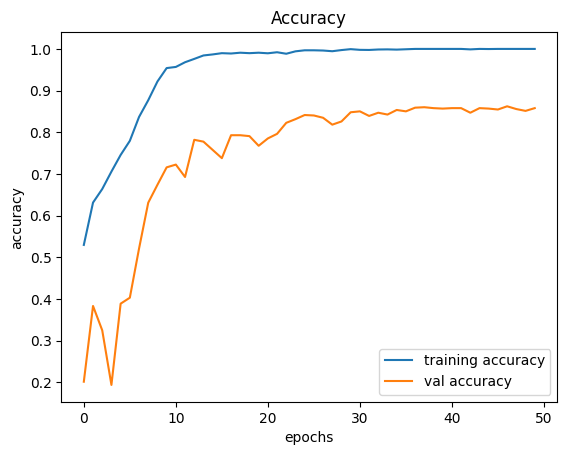

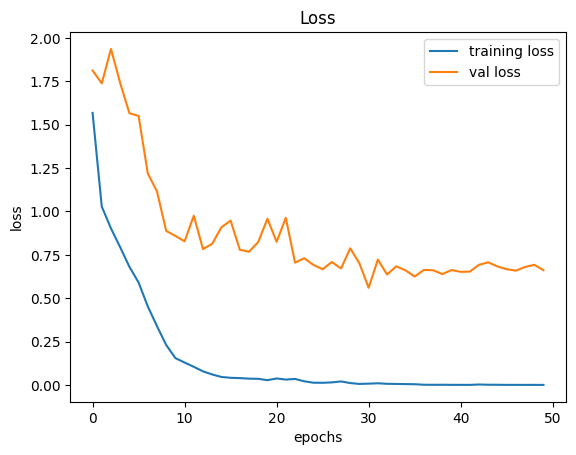

In [100]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Test Section

In [35]:
test_df = pd.read_csv("test.csv")
test_df

,audio_id,audio,speaker_id,gender,emotion,transcript,ipa
0,F21A48,{'bytes': b'RIFF\x12\xe7\x03\x00WAVEfmt \x10\x...,F21,female,angry,من به سکوت تو بیشتر از احترامت احتیاج دارم,mæn be sokute to biʃtær ʔæz ʔehterɑmet ʔehtiyɑ...
1,F07S42,{'bytes': b'RIFF(P\x06\x00WAVEfmt \x10\x00\x00...,F07,female,sad,پس درسته که خودکشی کرده، تو همون خونۀ واریکینو,pӕs doroste ke xodkoʃi kӕrde tu hӕmun xuneye v...
2,F09F02,{'bytes': b'RIFF2\x06\x04\x00WAVEfmt \x10\x00\...,F09,female,fearful,نه، نه، تو رو خدا نزارین بیاد اینجا.,nӕ nӕ to ro xodɑ nӕzɑrin biyɑ ʔindʒɑ
3,M26A14,{'bytes': b'RIFF~\xaa\x01\x00WAVEfmt \x10\x00\...,M26,male,angry,﻿زود باش، بُکُش,﻿zud bɑʃ bokoʃ
4,M37N09,{'bytes': b'RIFF\x90\x9e\x02\x00WAVEfmt \x10\x...,M37,male,neutral,کمتر کسی از این مرد چیزی می‎دونه,kæmtær kæsi ʔæz ʔin mærd tʃizi midune
...,...,...,...,...,...,...,...
563,M25H01,{'bytes': b'RIFF\xf6\x16\x04\x00WAVEfmt \x10\x...,M25,male,happy,من الان در تنهایی کاملاً خوشبختم,mæn ʔӕlɑn dær tӕnhɑyi kɑmelæn xoʃbӕxtӕm
564,F28N03,{'bytes': b'RIFF\xee5\x07\x00WAVEfmt \x10\x00\...,F28,female,neutral,زندگی توی این دنیا برای هیوبرت سخت‌تر از توئه.,zendegi tuye ʔin donyɑ bærɑye hiyubert sæxttær...
565,M16A04,{'bytes': b'RIFF:h\x06\x00WAVEfmt \x10\x00\x00...,M16,male,angry,یه عمر به هر دری که زدم نشد، هر کلکی که سوار ک...,ye ʔomr be hær dæri ke zædæm næʃod hær kælæki ...
566,M36S06,{'bytes': b'RIFF\xfc\xa6\x03\x00WAVEfmt \x10\x...,M36,male,sad,مری دیروز صبح به بوستون رفت,meri diruz sobe be boston ræft


In [ ]:
test_audios = get_audios(test_df)
len(test_audios)

In [ ]:
T = get_audios_feature(test_df)

In [103]:
test_audio_df = pd.DataFrame(T)
test_audio_df

,0,1,2,3,4,5,6,7,8,9,...,42494,42495,42496,42497,42498,42499,42500,42501,42502,42503
0,0.108887,0.109863,0.113770,0.008789,0.012695,0.016113,0.016602,0.016602,0.019043,0.023926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.207031,0.276367,0.286133,0.175781,0.089355,0.025879,0.020508,0.018555,0.020996,0.024902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.030762,0.047852,0.059082,0.062012,0.068848,0.066895,0.063477,0.046387,0.028320,0.016602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.254395,0.368652,0.484863,0.457031,0.388184,0.345703,0.265625,0.170898,0.124023,0.070312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020996,0.034180,0.044922,0.079590,0.077637,0.085938,0.098633,0.082031,0.091797,0.086914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,0.250000,0.376465,0.500977,0.490723,0.480957,0.480469,0.472168,0.460449,0.469238,0.465332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1132,0.097168,0.099609,0.110840,0.040039,0.017090,0.017090,0.007324,0.005371,0.007324,0.009766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1133,0.259277,0.375977,0.496094,0.489258,0.428223,0.415039,0.328125,0.224121,0.159668,0.068848,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1134,0.273438,0.325195,0.351074,0.186035,0.181152,0.189941,0.231934,0.257324,0.261719,0.272461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
test_audio_df = test_audio_df.iloc[:, :2000]
test_audio_df = test_audio_df.fillna(0)
test_audio_df

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.108887,0.109863,0.113770,0.008789,0.012695,0.016113,0.016602,0.016602,0.019043,0.023926,...,18.653809,9.180393,-0.910244,-6.001695,-5.360293,-3.853019,-3.562138,-2.253936,-1.054084,-4.150629
1,0.207031,0.276367,0.286133,0.175781,0.089355,0.025879,0.020508,0.018555,0.020996,0.024902,...,8.669705,4.896947,7.061246,7.282898,2.920508,-3.256845,-3.618269,0.581820,-1.490905,-2.640985
2,0.030762,0.047852,0.059082,0.062012,0.068848,0.066895,0.063477,0.046387,0.028320,0.016602,...,-339.707581,112.905563,-53.682667,16.762653,24.798710,51.260223,38.958603,-37.478455,5.034298,23.051947
3,0.254395,0.368652,0.484863,0.457031,0.388184,0.345703,0.265625,0.170898,0.124023,0.070312,...,-157.119341,8.153464,0.483782,3.471268,14.712191,16.222795,6.801794,-1.720343,-0.006820,4.840897
4,0.020996,0.034180,0.044922,0.079590,0.077637,0.085938,0.098633,0.082031,0.091797,0.086914,...,-1.556392,-2.572023,-4.396616,-5.268140,-5.936219,-7.237752,-569.420410,12.966881,12.651259,12.134336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,0.250000,0.376465,0.500977,0.490723,0.480957,0.480469,0.472168,0.460449,0.469238,0.465332,...,-2.684621,-1.669109,-4.221152,-2.611825,-0.207864,5.612001,2.922778,2.358252,-3.428723,-3.164083
1132,0.097168,0.099609,0.110840,0.040039,0.017090,0.017090,0.007324,0.005371,0.007324,0.009766,...,-154.838776,20.201130,18.724064,-35.471603,31.908966,-16.501141,-29.285336,60.834015,6.861668,-50.850174
1133,0.259277,0.375977,0.496094,0.489258,0.428223,0.415039,0.328125,0.224121,0.159668,0.068848,...,-71.815684,12.953260,15.437611,-6.061546,19.810833,-16.377275,-10.199458,37.957930,-6.566487,-26.411455
1134,0.273438,0.325195,0.351074,0.186035,0.181152,0.189941,0.231934,0.257324,0.261719,0.272461,...,-274.905701,132.744843,-66.204514,77.061226,9.253457,5.083659,30.262512,-29.339966,22.092762,9.944078


In [105]:
test_labels = []
for i in range(len(test_df)):
    emotion = test_df.iloc[i]["emotion"]
    test_labels.append(change_label_to_num(emotion))
    test_labels.append(change_label_to_num(emotion))


In [106]:
encoder = OneHotEncoder()
Y_test = encoder.fit_transform(np.array(test_labels).reshape(-1,1)).toarray()
X_test = test_audio_df.iloc[:, :-1].values

In [107]:
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

In [108]:
x_test_cnn = np.expand_dims(X_test, axis=2)

In [109]:
Y_test = Y_test[:x_test_cnn.shape[0]]
x_test_cnn = x_test_cnn[:Y_test.shape[0]]
test_loss, test_acc = model.evaluate(x_test_cnn, Y_test)
print('Test Accuracy:', test_acc)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6036 - loss: 2.2017
Test Accuracy: 0.6047534942626953
